# Logisitic regression

# 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,plot_precision_recall_curve,plot_roc_curve,plot_confusion_matrix,confusion_matrix,accuracy_score,roc_curve, auc


# 2. Reading data from file 

In [2]:
# global Variables
random_state = 55 # random_state variable is chosen to be 3 for all algorithms to ensure fair comparison

In [3]:
df = pd.read_csv('data.csv',index_col=0)
df.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


# 3. Pre-processing for data

## 3.1 Calculate upper and lower bounds

In [4]:
# **Get outliers and remove it**

# finding the 1st quartile
q1 = np.quantile(np.array(df['age']), 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(np.array(df['age']), 0.75)
med = np.median(np.array(df['age']))
 
# finding the iqr region
iqr = q3-q1

# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(upper_bound)
print(lower_bound)

82.5
14.5


## 3.2 Remove rows with outlier values 

863
Total number of age outliers removed: 27
836


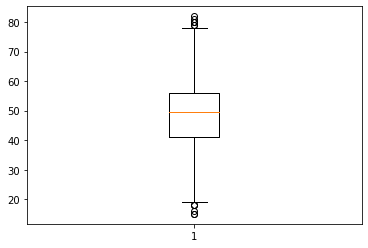

In [5]:
count = 0
df_with_outliers = df
print(len(df['age']))
for i in range(len(df['age'])):
  if df['age'][i] >= upper_bound or df['age'][i] <= lower_bound: # check boundary values 82.5 and 14.5
    count = count + 1
    df = df.drop(axis = 0, labels = i) # Remove rows includes outlier 
print(f"Total number of age outliers removed: {count}")

print(len(df['age']))
# Graph of the modified box-plot for age 
plt.boxplot(df['age'])
plt.show
df = df.reset_index(drop=True) # To reset the index after removal of rows 


<AxesSubplot:xlabel='result', ylabel='count'>

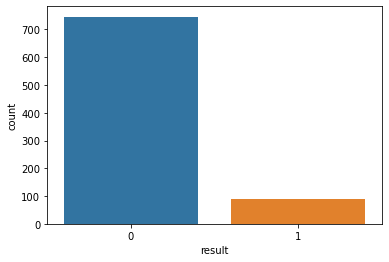

In [6]:
sns.countplot(x='result',data=df)

## 3.3 Splitting the data into features and labels

In [7]:
X = df.drop(['result'],axis=1)
y = df['result']


# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

# Split the training into training and validation 
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.1, random_state = 100) 

X_train = X_train.reset_index(drop=True) 
X_validate = X_validate.reset_index(drop=True) 
X_test = X_test.reset_index(drop=True) 
y_train = y_train.reset_index(drop=True) 
y_validate = y_validate.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True) 

## 3.4 Scaling of input and data 

In [8]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# 4. Logistic regression model training

## 4.1 The model 

In [9]:
#Logistic model
# Depending on warnings you may need to adjust max iterations allowed 
# Or experiment with different solvers
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=10000)

## 4.2 Parameters for GridSearch CV

In [10]:
# Penalty Type
penalty = ['l1', 'l2']

# Use logarithmically spaced C values (recommended in official docs)
C = np.logspace(0, 4, 10)

## 4.3 GridSearchCV in action 

In [11]:
grid_model = GridSearchCV(log_model,param_grid={'C':C,'penalty':penalty})
print(grid_model)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})


## 4.4 Fitting the model 

In [12]:
grid_model.fit(scaled_X_train,y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [13]:
grid_model.best_params_

{'C': 2.7825594022071245, 'penalty': 'l1'}

## 4.5 Make predctions using the model

In [14]:
y_pred = grid_model.predict(scaled_X_test)

# 5. Visualization 

## 5.1 Confusion matrix

In [15]:
confusion_matrix(y_test,y_pred)

array([[145,   4],
       [  2,  17]], dtype=int64)

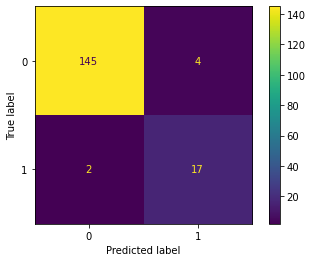

In [16]:
plot_confusion_matrix(grid_model,scaled_X_test,y_test)

In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       149
           1       0.81      0.89      0.85        19

    accuracy                           0.96       168
   macro avg       0.90      0.93      0.91       168
weighted avg       0.97      0.96      0.97       168



## 5.2 ROC/AUC curves 

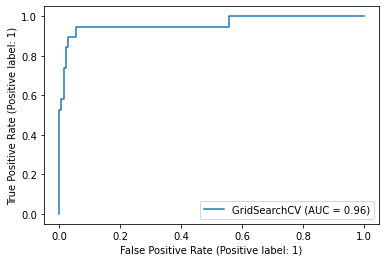

In [18]:
plot_roc_curve(grid_model,scaled_X_test,y_test)